<a href="https://colab.research.google.com/github/jickysid/Projects/blob/master/VGG16Pascal(%26_steel_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
#%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from google.colab.patches import cv2_imshow


In [0]:
#mounting google drive to load data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# parameters(VGG16)
im_width = 224
im_height = 224
border = 5


In [0]:
# parameters(UNET)
im_width1 = 128
im_height1 = 128
border = 5

In [0]:
#for creating array consisting name of images
#Use this if a text file containing the images is present. If not, Use ids = os.listdir (Present in loading the training data)
def file_read(fname):
        content_array = []
        content_array_1 = []
        with open(fname) as f:
                #Content_list is the list that contains the read lines.     
                
                for line in f:
                        if line.endswith('\n'):
                            line = line[:-1]
                            content_array.append(line + ".jpg")
                            content_array_1.append(line)
        return content_array, content_array_1


ids,ids_1 = file_read('/content/gdrive/My Drive/Colab Notebooks/Pascal VOC 12/trainval.txt') #file containing the names of images
print(ids)


['2007_000032.jpg', '2007_000033.jpg', '2007_000039.jpg', '2007_000042.jpg', '2007_000061.jpg', '2007_000063.jpg', '2007_000068.jpg', '2007_000121.jpg', '2007_000123.jpg', '2007_000129.jpg', '2007_000170.jpg', '2007_000175.jpg', '2007_000187.jpg', '2007_000241.jpg', '2007_000243.jpg', '2007_000250.jpg', '2007_000256.jpg', '2007_000323.jpg', '2007_000332.jpg', '2007_000333.jpg', '2007_000346.jpg', '2007_000363.jpg', '2007_000364.jpg', '2007_000392.jpg', '2007_000452.jpg', '2007_000464.jpg', '2007_000480.jpg', '2007_000491.jpg', '2007_000504.jpg', '2007_000515.jpg', '2007_000528.jpg', '2007_000529.jpg', '2007_000549.jpg', '2007_000559.jpg', '2007_000572.jpg', '2007_000584.jpg', '2007_000629.jpg', '2007_000636.jpg', '2007_000645.jpg', '2007_000648.jpg', '2007_000661.jpg', '2007_000663.jpg', '2007_000676.jpg', '2007_000713.jpg', '2007_000720.jpg', '2007_000727.jpg', '2007_000733.jpg', '2007_000738.jpg', '2007_000762.jpg', '2007_000768.jpg', '2007_000783.jpg', '2007_000793.jpg', '2007_00079

In [0]:
#for loading the ground truth
def get_mask(id_1):
    masks = np.zeros((6,im_height, im_width,1), dtype=np.float32)
    for i in range(1,7):
      mask = load_img("/content/gdrive/My Drive/Colab Notebooks/Pascal VOC 12/Segmentation_MaskB/"+id_1+str(i)+".png",grayscale=True) #folder containing the masks
      masks[i-1] = img_to_array(mask)
    return masks

In [0]:
# LOADING TRAINING DATA
#ids = os.listdir('/content/gdrive/My Drive/Colab Notebooks/images') # list of names all images in the given path
X = np.zeros((len(ids), im_height, im_width,1), dtype=np.float32)
y = np.zeros((len(ids_1), im_height, im_width,6), dtype=np.int8)

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/gdrive/My Drive/Colab Notebooks/Pascal VOC 12/Final/"+id_,grayscale=True) #folder containing the training images
    x_img = img_to_array(img)
    
    # Save images
    X[n] = x_img/255.0
    
for n_1, id_1 in tqdm_notebook(enumerate(ids_1), total=len(ids_1)):
    # Load masks
    mask = get_mask(id_1)
    mask = np.reshape(mask,(6,224,224))
    mask = mask.transpose((1, 2, 0))

    # Save masks
    y[n_1] = mask/255.0


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
print(X.shape,y.shape)

(2913, 224, 224, 1) (2913, 224, 224, 6)


In [0]:
# splitting the training data set and erasing the original training array
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X = []
y = []

In [0]:
#counting number of images in each class
c = 0
for i in range(0,len(y_train)):
  if(np.count_nonzero(y_train[i,:,:,5])>0):
    c = c + 1
print(c)

154


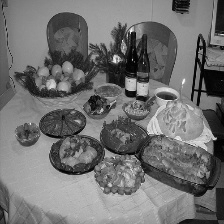

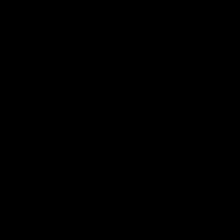

In [0]:
cv2_imshow(X_train[0,:,:,0]*255)
cv2_imshow(y_train[0,:,:,0]*255)

Text(0.5, 1.0, 'Ground Truth')

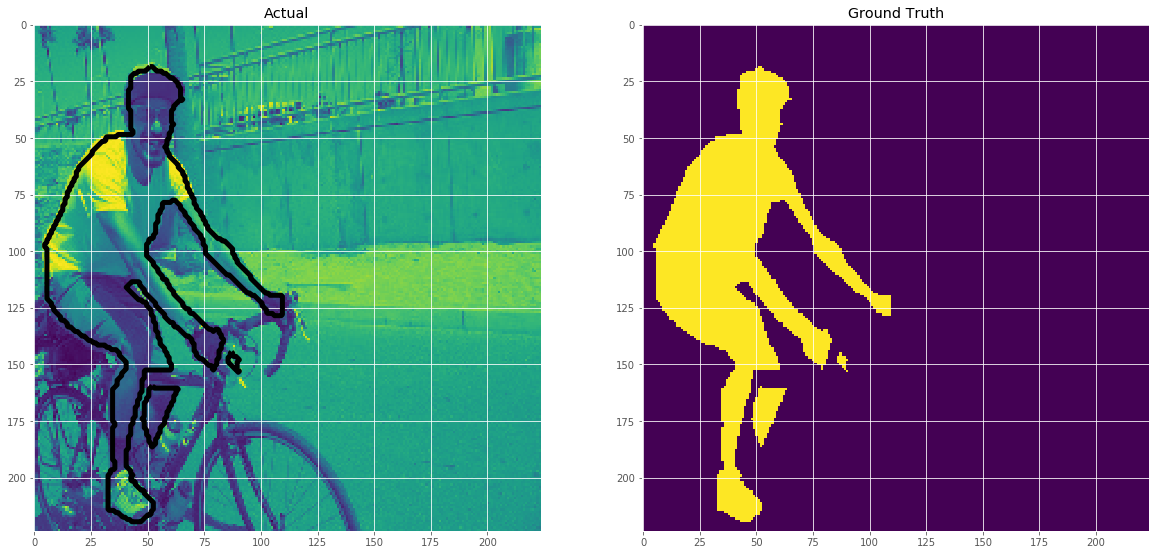

In [0]:
#Visualisation of training data images and mask
#ix = random.randint(0, len(X_train))
ix = 13
iy = 3
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0])
if has_mask: # if salt draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix,:,:,0].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Actual')

ax2.imshow(y_train[ix,:,:,0].squeeze())
ax2.set_title('Ground Truth')

In [0]:
#Function to add 2 convolutional layers with the parameters passed to it
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:ii
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


In [0]:
#Function to add 3 convolutional layers with the parameters passed to it
def conv2d_block1(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # third layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


In [0]:
def get_vgg16(input_img, n_filters = 64, dropout = 0.1, batchnorm = True):
    """Function to define the VGG16 Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
  
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    
    
    c3 = conv2d_block1(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv2d_block1(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = conv2d_block1(p4, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p5 = MaxPooling2D((2, 2))(c5)
    
    # FCN converted to CNN
    c0 = Conv2D(6, (1,1), activation = 'relu')(p5)
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c0)
    u6 = concatenate([u6, c5])
    c6 = conv2d_block1(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c4])
    c7 = conv2d_block1(u7, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c3])
    c8 = conv2d_block1(u8, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c2])
    c9 = conv2d_block(u9, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u10 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c9)
    u10 = concatenate([u10, c1])
    c10 = conv2d_block(u10, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(6, (1, 1), activation='sigmoid')(c10)
    modelVGG = Model(inputs=[input_img], outputs=[outputs])
    return modelVGG



input_img = Input((im_height, im_width, 1), name='img')
modelVGG = get_vgg16(input_img, n_filters=32, dropout=0.05, batchnorm=True)
modelVGG.compile(optimizer=Adam(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])

modelVGG.summary()


W0707 12:51:02.845069 140632394086272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 12:51:02.896168 140632394086272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 12:51:02.898452 140632394086272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0707 12:51:02.948895 140632394086272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0707 12:51:02.950062

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 224, 224, 32) 128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 224, 224, 32) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

In [0]:
#stop earlier even if epochs are not completed but purpose is served(VGG16)
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model-Pascal2012-VGG16E-50-H-.h5', verbose=1, save_best_only=True)
]

results = modelVGG.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))



Train on 2621 samples, validate on 292 samples
Epoch 1/50
2621/2621 [==============================] - 81s 31ms/step - loss: 0.3143 - acc: 0.9504 - val_loss: 0.2039 - val_acc: 0.9833

Epoch 00001: val_loss improved from inf to 0.20387, saving model to /content/gdrive/My Drive/Colab Notebooks/model-Pascal2012-VGG16E-50-H-.h5
Epoch 2/50
2621/2621 [==============================] - 66s 25ms/step - loss: 0.1408 - acc: 0.9826 - val_loss: 0.1407 - val_acc: 0.9833

Epoch 00002: val_loss improved from 0.20387 to 0.14075, saving model to /content/gdrive/My Drive/Colab Notebooks/model-Pascal2012-VGG16E-50-H-.h5
Epoch 3/50
2621/2621 [==============================] - 66s 25ms/step - loss: 0.0995 - acc: 0.9826 - val_loss: 0.1257 - val_acc: 0.9833

Epoch 00003: val_loss improved from 0.14075 to 0.12568, saving model to /content/gdrive/My Drive/Colab Notebooks/model-Pascal2012-VGG16E-50-H-.h5
Epoch 4/50
2621/2621 [==============================] - 66s 25ms/step - loss: 0.0859 - acc: 0.9826 - val_los

In [0]:
#UNET
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    modelUNET = Model(inputs=[input_img], outputs=[outputs])
    return modelUNET


#print(keras.optimizers.Adam())
input_img1 = Input((im_height1, im_width1, 1), name='img1')
modelUNET = get_unet(input_img1, n_filters=16, dropout=0.05, batchnorm=True)
modelUNET.compile(optimizer=Adam(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])
modelUNET.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img1 (InputLayer)               (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 16) 160         img1[0][0]                       
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 128, 128, 16) 64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 128, 128, 16) 0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
max_poolin

In [0]:
#stop earlier even if epochs are not completed but purpose is served(UNET)
callbacks1 = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model-Pascal-UNET-H-50.h5', verbose=1, save_best_only=True)
]

results1 = modelUNET.fit(X_train1, y_train1, batch_size=32, epochs=50, callbacks=callbacks1,\
                    validation_data=(X_valid1, y_valid1))


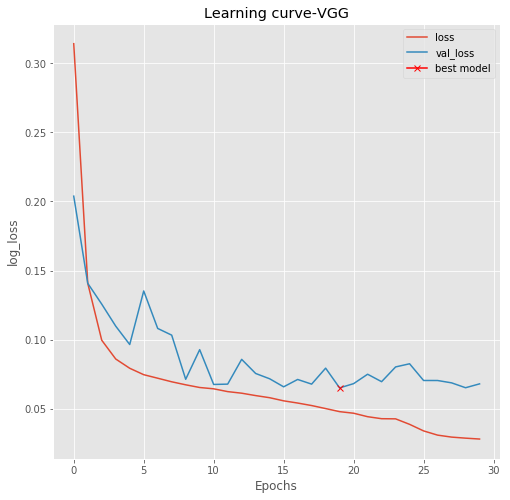

In [0]:
#plotting the learning curve(VGG16)
plt.figure(figsize=(8, 8))
plt.title("Learning curve-VGG")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


In [0]:
#plotting the learning curve(UNET)
plt.figure(figsize=(8, 8))
plt.title("Learning curve-UNET")
plt.plot(results1.history["loss"], label="loss")
plt.plot(results1.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results1.history["val_loss"]), np.min(results1.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


In [0]:
#LOADING TRAINED MODEL

#modelUNET = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/model-tgs-salt-UNET.h5')

In [0]:
# LOADING TESTING DATA
ids = os.listdir('/content/gdrive/My Drive/Colab Notebooks/testing_images') # list of names all images in the given path
#print("No. of images = ", len(ids))

X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/gdrive/My Drive/Colab Notebooks/testing_images/"+id_, grayscale=True) #folder containing the testing data
    x_img = img_to_array(img)
    x_img1 = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True
    # Save images
    X[n] = x_img/255.0
    #X1[n] = x_img1/255.0


In [0]:
# re-initialising arrays to avoid crashing
preds_train = []
preds_val = []
preds_train_t = []
preds_val_t = []

In [0]:
#(VGG16)
t = 0.2
# Predict on train, val and test
preds_train = modelVGG.predict(X_train, verbose=1)
preds_val = modelVGG.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > t).astype(np.uint8)
preds_val_t = (preds_val > t).astype(np.uint8)



292/292 [==============================] - 3s 9ms/step


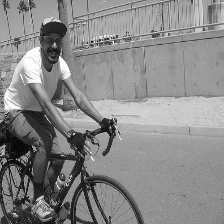

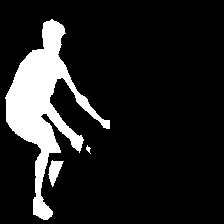

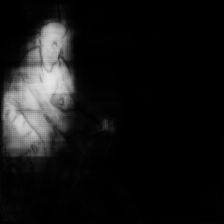

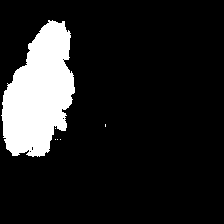

In [0]:
x = 13
z = 0
cv2_imshow(X_train[x,:,:,0]*255)
cv2_imshow(y_train[x,:,:,z]*255)
cv2_imshow(preds_train[x,:,:,z]*255)
cv2_imshow(preds_train_t[x,:,:,z]*255)

In [0]:
#UNET
p = 0.2
# Predict on train, val and test
preds_train1 = modelUNET.predict(X_train1, verbose=1)
preds_val1 = modelUNET.predict(X_valid1, verbose=1)

# Threshold predictions
preds_train_t1 = (preds_train1 > p).astype(np.uint8)
preds_val_t1 = (preds_val1 > p).astype(np.uint8)

292/292 [==============================] - 0s 648us/step


In [0]:
def plot_sample(X, y, preds, binary_preds,s, ix=None):
    """Function to plot the results"""
    s = s
    if ix is None:
        ix = random.randint(0, len(X))
    print(ix)
    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0])
    #if has_mask:
    #    ax[0].contour(y[ix].squeeze(), colors='gray', levels=[0.5])
    ax[0].set_title('original image')

    ax[1].imshow(y[ix,:,:,s].squeeze())
    ax[1].set_title('ground truth')

    ax[2].imshow(preds[ix,:,:,s].squeeze(), vmin=0, vmax=1)
    #if has_mask:
    #    ax[2].contour(y[ix].squeeze(), colors='gray', levels=[0.5])
    ax[2].set_title(' Predicted')
    
    ax[3].imshow(binary_preds[ix,:,:,s].squeeze(), vmin=0, vmax=1)
    #if has_mask:
    #    ax[3].contour(y[ix].squeeze(), colors='gray', levels=[0.5])
    ax[3].set_title('Predicted binary');

1712


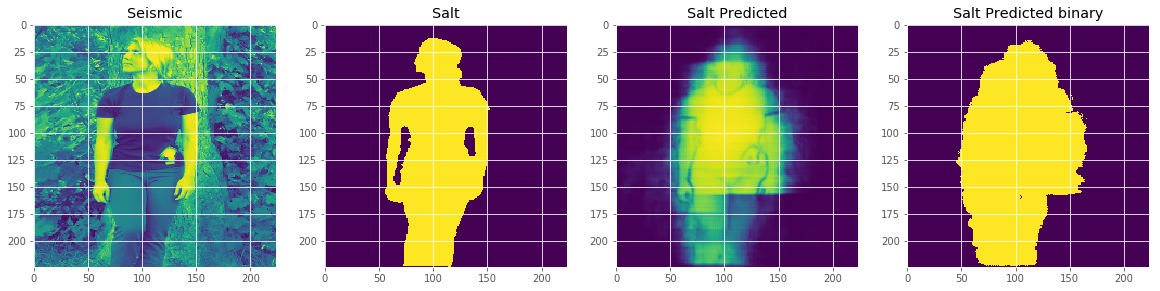

In [0]:
#VGG16(TRAINING SET)
plot_sample(X_train, y_train, preds_train, preds_train_t,0,1712)


In [0]:

#UNET(TRAINING SET)
plot_sample(X_train1, y_train1, preds_train1, preds_train_t1)

209


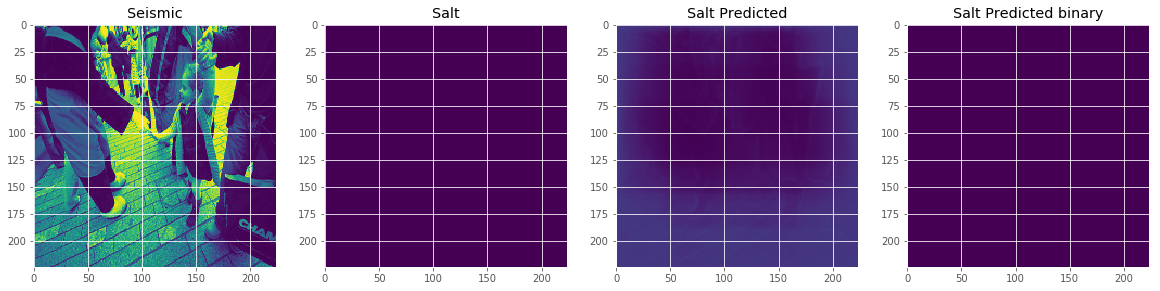

In [0]:
#VGG16(VALIDATION SET)
plot_sample(X_valid, y_valid, preds_val, preds_val_t,1,209)

In [0]:
#UNET(VALIDATION SET)
plot_sample(X_valid1, y_valid1, preds_val1, preds_val_t1)